## SNP typing and lineage naming from WGS using reference population

References:

* https://www.frontiersin.org/articles/10.3389/fmicb.2020.00843/full
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3502966/

Selection of reference population:

* Global
* European
* UK/Ireland
* All Ireland (republic + NI)

required: 

* We need to be able to add new samples to the existing **reference** population phylogeny without having to re-analyse everything together.
* We need to have a sufficiently sampled reference matrix that it will cover most potential new inputs. Otherwise they will be considered outgroups.

Method: 

* add one or more samples to an existing population snp matrix - concatenate two sets of snps into one matrix by keeping only the polymorphic sites in the reference matrix. sites not present in the unknown samples are replaced with Ns
* generate a new phylogeny from the combined snp matrix
* identify the unknown isolates from their clade/position in phylogeny - how do we name the clades/lineages?


In [135]:
from IPython.display import Image
Image(url='https://www.frontiersin.org/files/Articles/509125/fmicb-11-00843-HTML/image_m/fmicb-11-00843-g001.jpg',width=700)

In [137]:
import numpy as np
import pandas as pd
import pylab as plt
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Phylo
import seaborn as sns
import toytree
from snipgenie import app, trees

In [11]:
snpmat = pd.read_csv('../snipgenie/data/ireland_snps.txt',sep=' ')
snpmat

,pos,ref,31-12952,48-MBovis,49-MBovis,28-12935,27-MBovis,15-11643,59-MBovis,182-MBovis,...,ERR125621,ERR125620,ERR125604,ERR125628,ERR125608,ERR125619,ERR125627,ERR125624,ERR125609,ERR125607
0,687,C,C,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C
1,937,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
2,1303,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,G,G,G
3,1456,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,G,G,G
4,1584,T,T,T,T,T,T,T,T,T,...,T,T,T,T,T,T,T,T,T,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,3832251,G,G,G,G,G,G,G,G,A,...,G,G,G,G,G,G,G,G,G,G
1742,3833590,G,G,G,G,G,G,G,G,G,...,A,A,A,A,A,A,A,A,A,A
1743,3835182,G,G,G,G,G,G,G,G,G,...,G,G,G,G,G,G,G,G,G,G
1744,3839650,T,C,C,C,C,C,C,C,T,...,T,T,T,T,T,T,T,T,T,T


/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


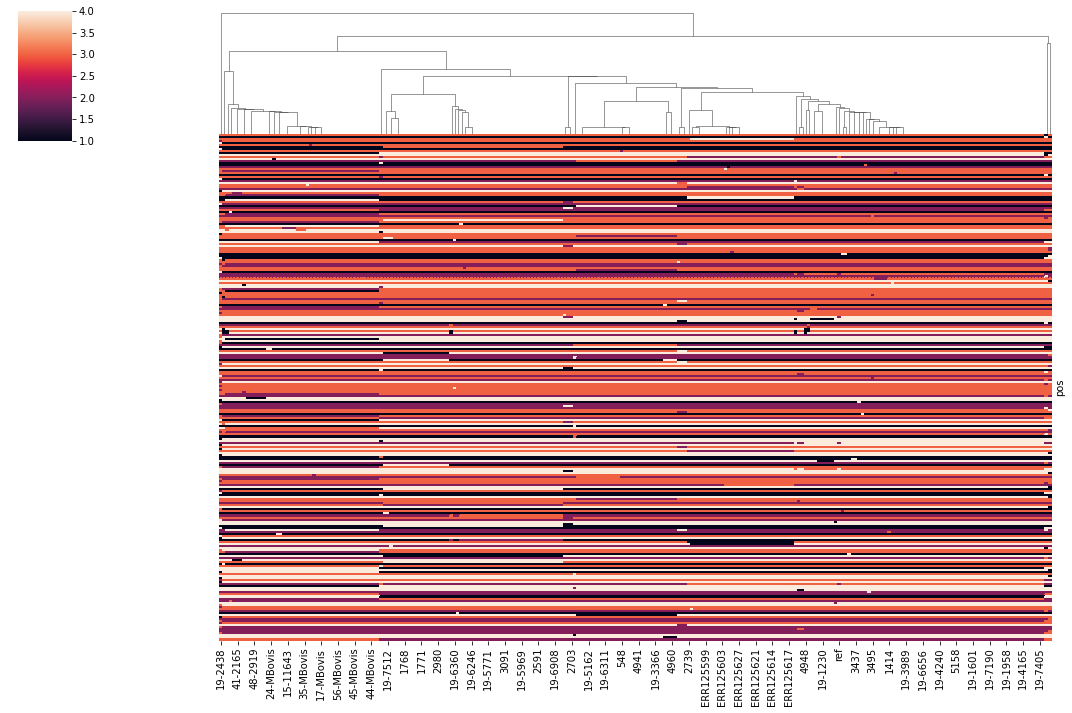

In [195]:
X=snpmat.set_index('pos').sample(250).sort_index()
mapping = {"A": 1, "T": 2, "C": 3, "G": 4}
X=X.replace(mapping)
sns.clustermap(X,row_cluster=False,yticklabels=False,figsize=(15,10))


In [ ]:
Y=X.copy()
from sklearn.cluster import KMeans
#km1 = KMeans(n_clusters=4).fit(x)
#x['l1'] = km1.labels_

for level in range(4,8):
    km = KMeans(n_clusters=level).fit(x)
    Y['l'+str(level)] = km.labels_
Y=Y.sort_values(['l4','l5','l6','l7'])   
Y['address'] = Y[['l4','l5','l6','l7']].astype(str).agg('-'.join, axis=1)
Y[30:50]

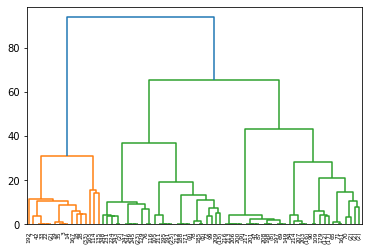

In [171]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(x.T)
model


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    #print (linkage_matrix)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plot_dendrogram(model, truncate_mode='level', p=5)



In [ ]:
def snps_to_fasta(snpmat, outfile):
    """Write snp matrix to fasta file"""
    
    snpmat = snpmat.fillna('N')
    recs = []
    for col in snpmat.columns[1:]:
        seq = ''.join(snpmat[col])        
        seqrec = SeqRecord(Seq(seq),id=col)
        recs.append(seqrec)
    SeqIO.write(recs, outfile, 'fasta')
    return    

def tree_from_snps(snpmat):
    snps_to_fasta(snpmat, 'snps.fa') 
    treefile = trees.run_fasttree('snps.fa')
    tre = toytree.tree(treefile)
    mystyle = { "layout": 'r','node_sizes':1,'tip_labels_align':False}
    tre.ladderize().draw(**mystyle,width=700);
    return tre

snps_to_fasta(snpmat, 'snps.fa')
tree_from_snps(snpmat)

## combine sub sample of snps with original matrix

In [ ]:
x=snpmat.set_index('pos').sample(150).sort_index()
m1 = x.sample(30,axis=1,random_state=2)
m1 = m1[2:]
m2 = x.sample(6,axis=1,random_state=5)
m2 = m2[:-4]
#print (m1)
    
tree_from_snps(m2)

In [129]:
print(m1[:5])
print(m2[:5])

      1768 183 19-6317 ERR125626 3263 ERR125606 19-6277 26-MBovis 54-MBovis  \
pos                                                                           
30864    T   T       T         T    T         T       T         T         T   
33083    C   C       C         C    C         C       C         C         C   
33145    C   C       C         C    C         C       C         C         C   
33788    A   A       A         A    A         A       A         G         G   
58397    G   G       G         G    G         G       G         G         G   

      5220  ... 4961 19-7348 ERR125620 55-4348 ERR125599 19-2597 1143 4946  \
pos         ...                                                              
30864    T  ...    T       T         T       T         T       T    T    T   
33083    C  ...    C       C         C       C         C       C    C    C   
33145    C  ...    C       C         C       C         C       C    C    C   
33788    A  ...    A       A         A       G         A

In [ ]:
new = m1.join(m2).fillna('N')
new
tree_from_snps(new)

In [ ]:
def concat_snp_matrices(ref, other):
    """
    join two snp matrices
    we assume there are no private or uninformative snps in the inputs
    if site is missing in the other matrix we assign an N there
    discard sites that are not in ref?
    """
    
    for i,r in other.iterrows():
        
    return

r = snpmat.set_index('pos').T

concat_snp_matrices(m1, m2)

In [24]:
treefile = trees.run_fasttree('snps.fa')

## naming clades from tree

In [ ]:
tree = Phylo.read(treefile, 'newick')
print (tree)

## run test data

* UK https://www.ncbi.nlm.nih.gov/bioproject/PRJNA523164

## simulate genomes

In [ ]:
ref = app.mbovis_genome
vcf_file='/'
cmd = 'perl /storage/btbgenie/simuG/simuG.pl \
     -refseq {r} \
     -snp_vcf {v} \
     -prefix output_prefix '.format(r=ref)